In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_excel("telecom_customer_churn_data.xlsx")

# Drop customer_id and separate features/target
df_model = df.drop(columns=['customer_id'])
X = df_model.drop(columns=['churned'])
y = df_model['churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred_rf = rf_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Confusion Matrix:
 [[21  1]
 [ 8  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82        22
           1       0.00      0.00      0.00         8

    accuracy                           0.70        30
   macro avg       0.36      0.48      0.41        30
weighted avg       0.53      0.70      0.60        30



C:\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:761: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


<Figure size 640x480 with 0 Axes>

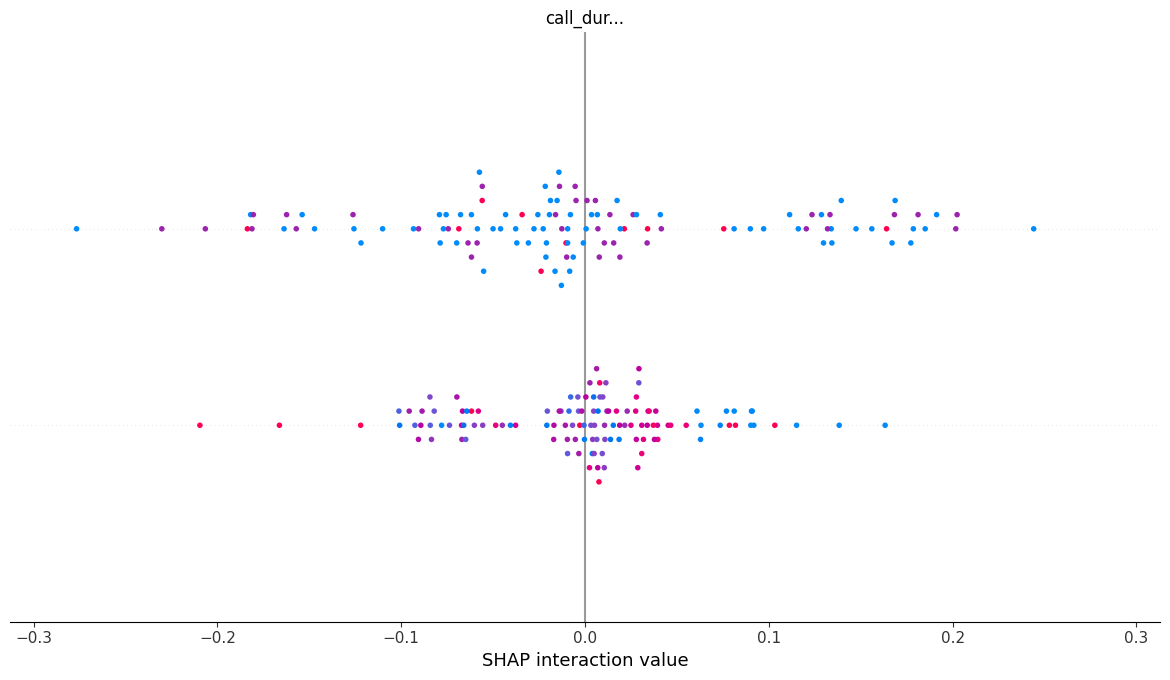

In [6]:
import shap

# New SHAP API works directly with your DataFrame
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_train)

# SHAP summary plot — this will work correctly
shap.summary_plot(shap_values, X_train)


In [7]:
# Predict churn probabilities on the full dataset
df_model['churn_probability'] = rf_model.predict_proba(X)[:, 1]

# Example segmentation logic (adjust thresholds as needed)
def segment_customer(row):
    if row['churn_probability'] > 0.6:
        return 'At Risk'
    elif row['churn_probability'] < 0.3 and row.get('tenure', 0) > 365:
        return 'Loyal'
    elif row.get('recharge_count', 0) < 2:
        return 'Dormant'
    else:
        return 'Others'

# Apply segmentation
df_model['segment'] = df_model.apply(segment_customer, axis=1)



In [8]:
# Quick summary of segments
segment_summary = df_model.groupby('segment').agg({
    'churn_probability': ['mean', 'count'],
    'recharge_count': 'mean' if 'recharge_count' in df_model.columns else 'count',
    'complaint_count': 'mean' if 'complaint_count' in df_model.columns else 'count'
}).reset_index()

segment_summary.columns = ['Segment', 'Avg Churn Prob', 'Customer Count', 'Avg Recharge Count', 'Avg Complaint Count']
print(segment_summary)


KeyError: "Column(s) ['complaint_count', 'recharge_count'] do not exist"

In [9]:
print(df_model.columns)


Index(['call_duration_last_month', 'num_complaints', 'recharge_frequency',
       'avg_recharge_amount', 'internet_usage_gb', 'days_since_last_login',
       'churned', 'churn_probability', 'segment'],
      dtype='object')


In [10]:
# List the columns that need to be aggregated
agg_columns = {
    'churn_probability': ['mean', 'count']
}

# Check if 'recharge_frequency' and 'num_complaints' exist before adding them
if 'recharge_frequency' in df_model.columns:
    agg_columns['recharge_frequency'] = 'mean'
else:
    agg_columns['recharge_frequency'] = 'count'

if 'num_complaints' in df_model.columns:
    agg_columns['num_complaints'] = 'mean'
else:
    agg_columns['num_complaints'] = 'count'

# Perform the aggregation
segment_summary = df_model.groupby('segment').agg(agg_columns).reset_index()

# Flatten the column multi-index if necessary
segment_summary.columns = ['Segment', 'Avg Churn Prob', 'Customer Count', 'Avg Recharge Frequency', 'Avg Complaint Count']
print(segment_summary)


   Segment  Avg Churn Prob  Customer Count  Avg Recharge Frequency  \
0  At Risk        0.742143              28                3.321429   
1  Dormant        0.125656             122                4.663934   

   Avg Complaint Count  
0             0.428571  
1             0.549180  


In [11]:
churn_rate = df_model.groupby('segment')['churned'].mean().reset_index()
churn_rate.columns = ['Segment', 'Churn Rate']
print(churn_rate)


   Segment  Churn Rate
0  At Risk    1.000000
1  Dormant    0.081967


In [12]:
correlation_matrix = df_model[['churn_probability', 'recharge_frequency', 'num_complaints', 'avg_recharge_amount', 'internet_usage_gb', 'days_since_last_login']].corr()
print(correlation_matrix)


                       churn_probability  recharge_frequency  num_complaints  \
churn_probability               1.000000           -0.203984       -0.090180   
recharge_frequency             -0.203984            1.000000        0.030048   
num_complaints                 -0.090180            0.030048        1.000000   
avg_recharge_amount            -0.074689           -0.166695       -0.113189   
internet_usage_gb              -0.053375            0.054657        0.195848   
days_since_last_login           0.127665           -0.014874       -0.052187   

                       avg_recharge_amount  internet_usage_gb  \
churn_probability                -0.074689          -0.053375   
recharge_frequency               -0.166695           0.054657   
num_complaints                   -0.113189           0.195848   
avg_recharge_amount               1.000000           0.007888   
internet_usage_gb                 0.007888           1.000000   
days_since_last_login            -0.066838       

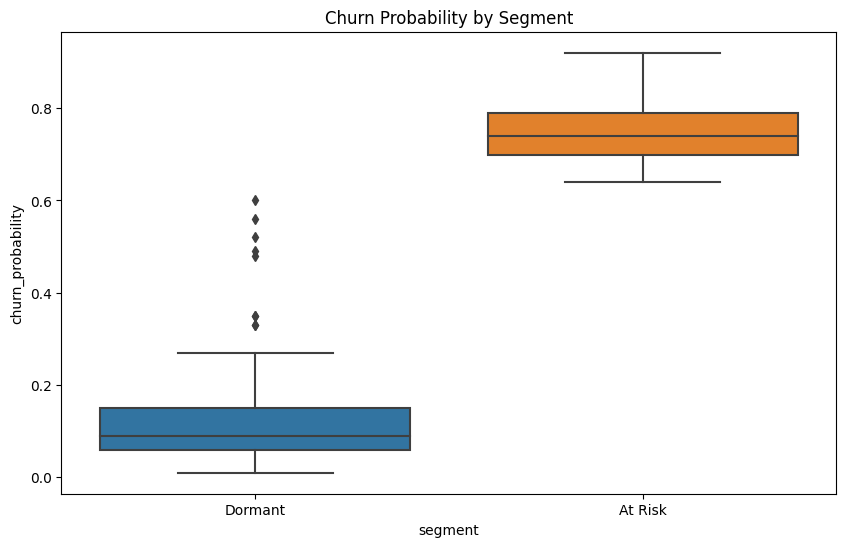

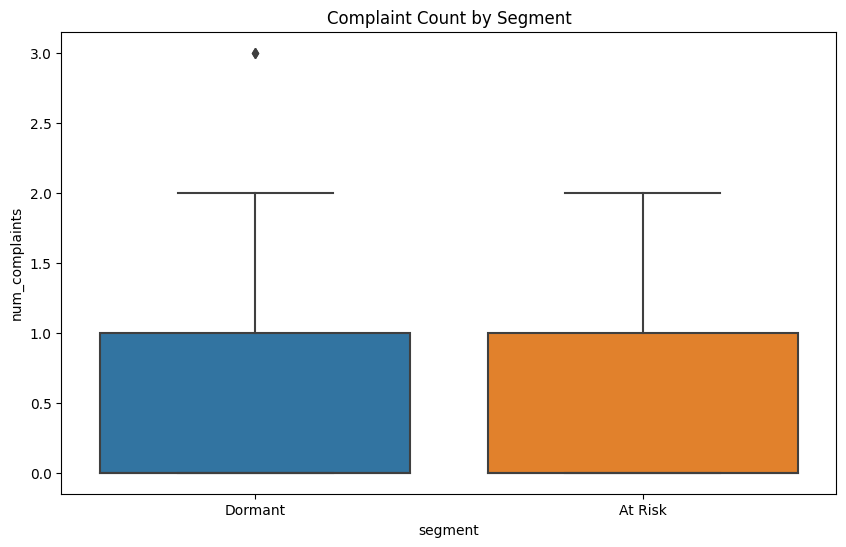

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Churn probability vs Recharge Frequency
plt.figure(figsize=(10, 6))
sns.boxplot(x='segment', y='churn_probability', data=df_model)
plt.title('Churn Probability by Segment')
plt.show()

# Churn probability vs Complaints
plt.figure(figsize=(10, 6))
sns.boxplot(x='segment', y='num_complaints', data=df_model)
plt.title('Complaint Count by Segment')
plt.show()


In [14]:
segment_profile = df_model.groupby('segment').agg({
    'recharge_frequency': ['mean', 'median', 'std'],
    'num_complaints': ['mean', 'median', 'std'],
    'avg_recharge_amount': ['mean', 'median', 'std'],
    'internet_usage_gb': ['mean', 'median', 'std'],
    'days_since_last_login': ['mean', 'median', 'std'],
}).reset_index()

print(segment_profile)


   segment recharge_frequency                  num_complaints         \
                         mean median       std           mean median   
0  At Risk           3.321429    2.5  3.399930       0.428571    0.0   
1  Dormant           4.663934    5.0  2.824365       0.549180    0.0   

            avg_recharge_amount                        internet_usage_gb  \
        std                mean      median        std              mean   
0  0.634126           97.960214   94.248114  36.818731         10.107709   
1  0.717001          107.106838  108.172915  32.476803         10.327806   

                       days_since_last_login                    
      median       std                  mean median        std  
0  10.806272  5.160564             38.535714   41.0  15.098399  
1  10.186423  5.512083             31.237705   34.0  16.643095  


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare data
features = df_model[['recharge_frequency', 'num_complaints', 'avg_recharge_amount', 'internet_usage_gb', 'days_since_last_login']]
target = df_model['churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Model training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.88      0.79        32
           1       0.33      0.15      0.21        13

    accuracy                           0.67        45
   macro avg       0.53      0.51      0.50        45
weighted avg       0.61      0.67      0.62        45



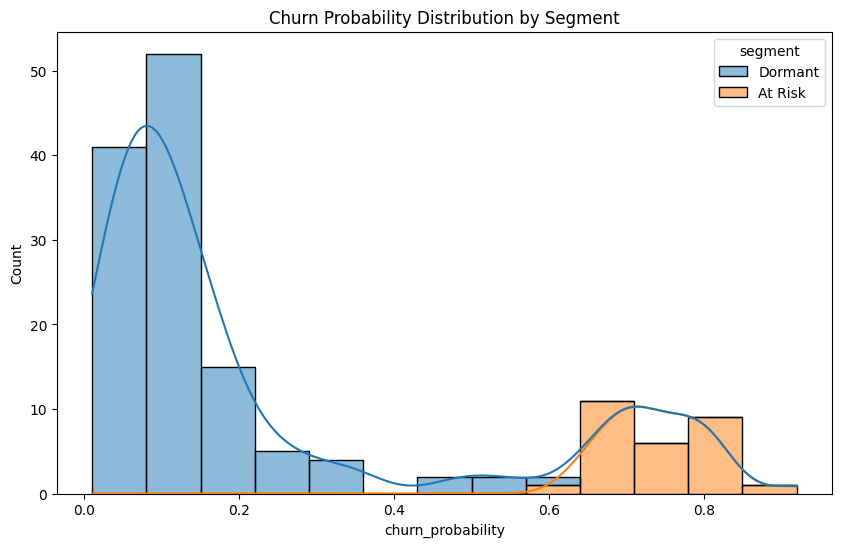

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_model, x='churn_probability', hue='segment', multiple="stack", kde=True)
plt.title('Churn Probability Distribution by Segment')
plt.show()


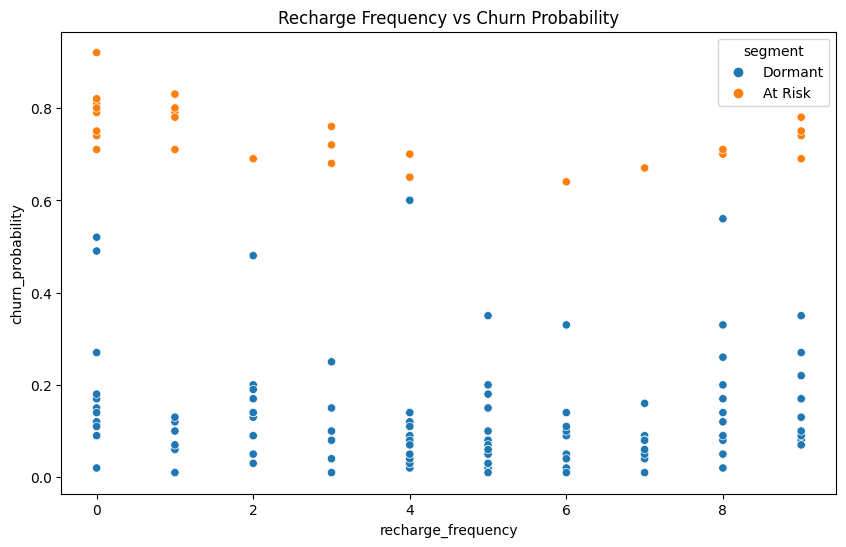

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_model, x='recharge_frequency', y='churn_probability', hue='segment')
plt.title('Recharge Frequency vs Churn Probability')
plt.show()


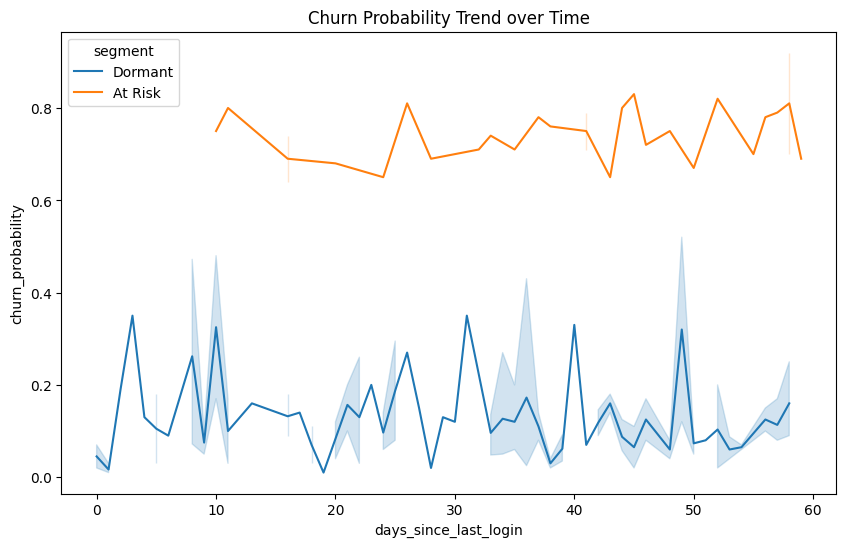

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_model, x='days_since_last_login', y='churn_probability', hue='segment')
plt.title('Churn Probability Trend over Time')
plt.show()


In [21]:
!pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5e/03/15cd49e855c62226ecf1831bbe4c8e73a4324856077a23c495538a36e557/xgboost-3.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 660.6 kB/s eta 0:03:47
   ---------------------------------------- 0.0/150.0 MB 495.5 kB/s eta 0:05:03
   ---------------------------------------- 0.0/150.0 MB 495.5 kB/s eta 0:05:03
   ---------------------------------------- 0.0/150.0 MB 495.5 kB/s eta 0:05:03
   ---------------------------------------- 0.1/150.0 MB 252.2 kB/s eta 0:09:55
   ---------------------------------------- 0.1/150.0 MB 409.6 kB/s eta 0:06:06
   ---------------------------------------- 0.1/150.0 MB 425.1 kB/s eta 0:05:53
   ---------------------------------------- 0.1/150.0 MB 426.7 kB/s eta 0:05:52
   ---------------------------------------- 0.2/150.0 MB 456.4 kB/s eta 0:05:29
   -


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Prepare the data for training
features = df_model[['recharge_frequency', 'num_complaints', 'avg_recharge_amount', 'internet_usage_gb', 'days_since_last_login']]
target = df_model['churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train the XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6222222222222222


C:\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


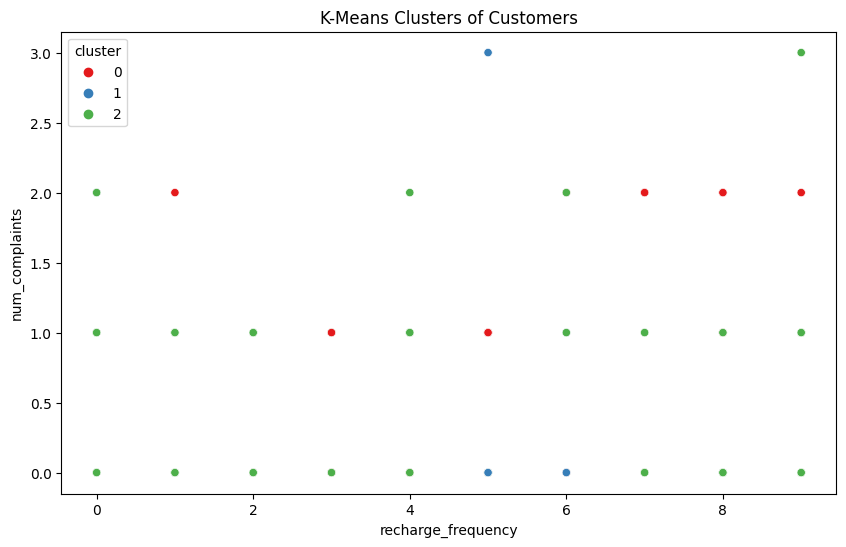

In [24]:
from sklearn.cluster import KMeans

# Prepare the features
features = df_model[['recharge_frequency', 'num_complaints', 'avg_recharge_amount', 'internet_usage_gb', 'days_since_last_login']]

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_model['cluster'] = kmeans.fit_predict(features)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_model, x='recharge_frequency', y='num_complaints', hue='cluster', palette='Set1')
plt.title('K-Means Clusters of Customers')
plt.show()


In [3]:
import pandas as pd

df = pd.read_excel("telecom_customer_churn_data.xlsx")


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(['customer_id', 'churned'], axis=1)
y = df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[21  1]
 [ 7  1]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        22
           1       0.50      0.12      0.20         8

    accuracy                           0.73        30
   macro avg       0.62      0.54      0.52        30
weighted avg       0.68      0.73      0.67        30



In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Reload data
import pandas as pd
df = pd.read_excel("telecom_customer_churn_data.xlsx")

# Prepare features
X = df.drop(['customer_id', 'churned'], axis=1)
y = df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

C:\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:761: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


<Figure size 640x480 with 0 Axes>

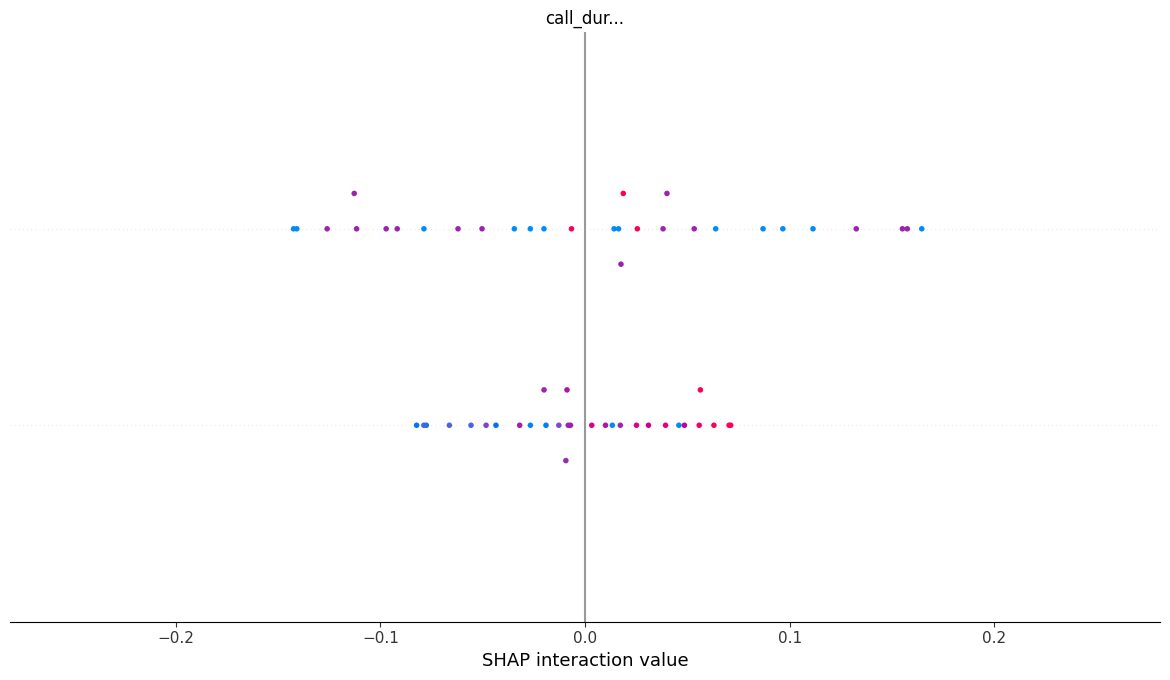

In [3]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


In [4]:
def segment_customer(row):
    if row['churned'] == 1 and row['num_complaints'] > 0:
        return "At Risk"
    elif row['churned'] == 0 and row['recharge_frequency'] >= 6:
        return "Loyal"
    elif row['days_since_last_login'] > 50:
        return "Dormant"
    else:
        return "General"

df['segment'] = df.apply(segment_customer, axis=1)


In [5]:
df['segment'].value_counts()


segment
General    83
Loyal      39
Dormant    15
At Risk    13
Name: count, dtype: int64